This notebook makes projections for the Gecco telescope. Currently it uses the same target region as COMPTEL and a background model derived from COMPTEL and EGRET data (see eq. 14 [here](https://arxiv.org/pdf/1504.04024)).

We need to think about what targets and background models make sense. We should probably do projections for the Galactic Center, dSphs, and ROIs of other experiments. One issue with dSph projections is that Gecco's angular resolution is quite poor ($\sim 6^\circ$), so we'll need to account for this properly.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import jupyter_beeper

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]
beeper = jupyter_beeper.Beeper()
def beep():
    return beeper.beep(frequency=900, secs=0.7, blocking=True)

In [17]:
from hazma.gamma_ray_parameters import egret_diffuse, fermi_diffuse, comptel_diffuse
from hazma.gamma_ray_parameters import A_eff_comptel, A_eff_egret, A_eff_fermi, energy_res_comptel
from hazma.gamma_ray_parameters import (
    gc_target, gc_bg_model, draco_target, default_bg_model
)
from hazma.gamma_ray_parameters import (
    A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam
)
from hazma.gamma_ray_parameters import (
    A_eff_gecco, energy_res_gecco, energy_res_gecco_large
)

from hazma.scalar_mediator import HiggsPortal, HeavyQuark
from hazma.vector_mediator import KineticMixing, QuarksOnly

# Setup and utils

In [34]:
# Masses to scan over
mx_min = 0.55  # a bit larger than m_e
mx_max = 250.
n_mxs = 50
mxs = np.geomspace(mx_min, mx_max, n_mxs)

# Other constants
T_obs_gecco = 1e6  # s. This is a VERY short time!
v_mw = 1e-3
x_kd = 1e-6


def get_sv_constraints(model, mxs=mxs):
    """
    Computes constraints on <sigma v> for a model over a grid of DM masses.
    """
    constraints = {k: np.zeros_like(mxs) for k in [
        "comptel", "egret", "fermi", "e_astrogam", "gecco", "gecco_large",
        "comptel_check", "cmb"
    ]}

    for i, mx in enumerate(mxs):
        model.mx = mx
        
        # Constraints from existing data
        constraints["comptel"][i] = model.binned_limit(comptel_diffuse)
        constraints["egret"][i] = model.binned_limit(egret_diffuse)
        constraints["fermi"][i] = model.binned_limit(fermi_diffuse)
        
        # Projections
        constraints["e_astrogam"][i] = model.unbinned_limit(
            A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam,
            gc_target, gc_bg_model
        )
        constraints["gecco"][i] = model.unbinned_limit(
            A_eff_gecco, energy_res_gecco, T_obs_gecco, comptel_diffuse.target,
            default_bg_model
        )
        constraints["gecco_large"][i] = model.unbinned_limit(
            A_eff_gecco, energy_res_gecco_large, T_obs_gecco, comptel_diffuse.target,
            default_bg_model
        )
        constraints["comptel_check"][i] = model.unbinned_limit(
            A_eff_comptel, energy_res_comptel, T_obs_gecco, comptel_diffuse.target,
            default_bg_model
        )
        
        # CMB
        constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)
    
    return constraints


def get_label(key):
    if key == "comptel_check":
        return "COMPTEL check"
    elif key == "e_astrogam":
        return "e-ASTROGAM"
    elif key == "gecco_large":
        return "GECCO (large)"
    else:
        return key.upper()


def get_formatted_fig(nrows, ncols, figsize, xlim, ylim):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for ax in axes[-1]:
        ax.set_xlabel(r"$m_\chi$ [MeV]")

    for ax in axes[:, 0]:
        ax.set_ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]")

    for ax in axes.flatten():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid()

    return fig, axes

# Higgs portal model

In [42]:
mss = [200, 1000]

sm_args = np.array([
    [{"mx": 1., "ms": ms, "gsxx": 1., "stheta": 0.1} for ms in mss],
    [{"mx": 1., "ms": ms, "gsxx": 1., "gsQ": 0.1, "mQ": 1000, "QQ": 1} for ms in mss],
])

SMs = np.array([
    [HiggsPortal, HiggsPortal],
    [HeavyQuark, HeavyQuark]
])

# Instantiate all the models
sms = np.vectorize(lambda SM, kwargs: SM(**kwargs))(SMs, sm_args)

# Load precomputed constraints
sv_constraints_sms = np.load(
    "data/sv_constraints_sms.npz", allow_pickle=True
)["sv_constraints_sms"]

In [14]:
# Recompute constraints
sv_constraints_sms = np.empty_like(sms)
for i in range(len(sms)):
    for j in range(len(sms[i])):
        sv_constraints_sms[i, j] = get_sv_constraints(sms[i, j], mxs)

# Save results
# np.savez(
#     "data/sv_constraints_sms.npz", sv_constraints_sms=sv_constraints_sms, sm_args=sm_args
# )

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)


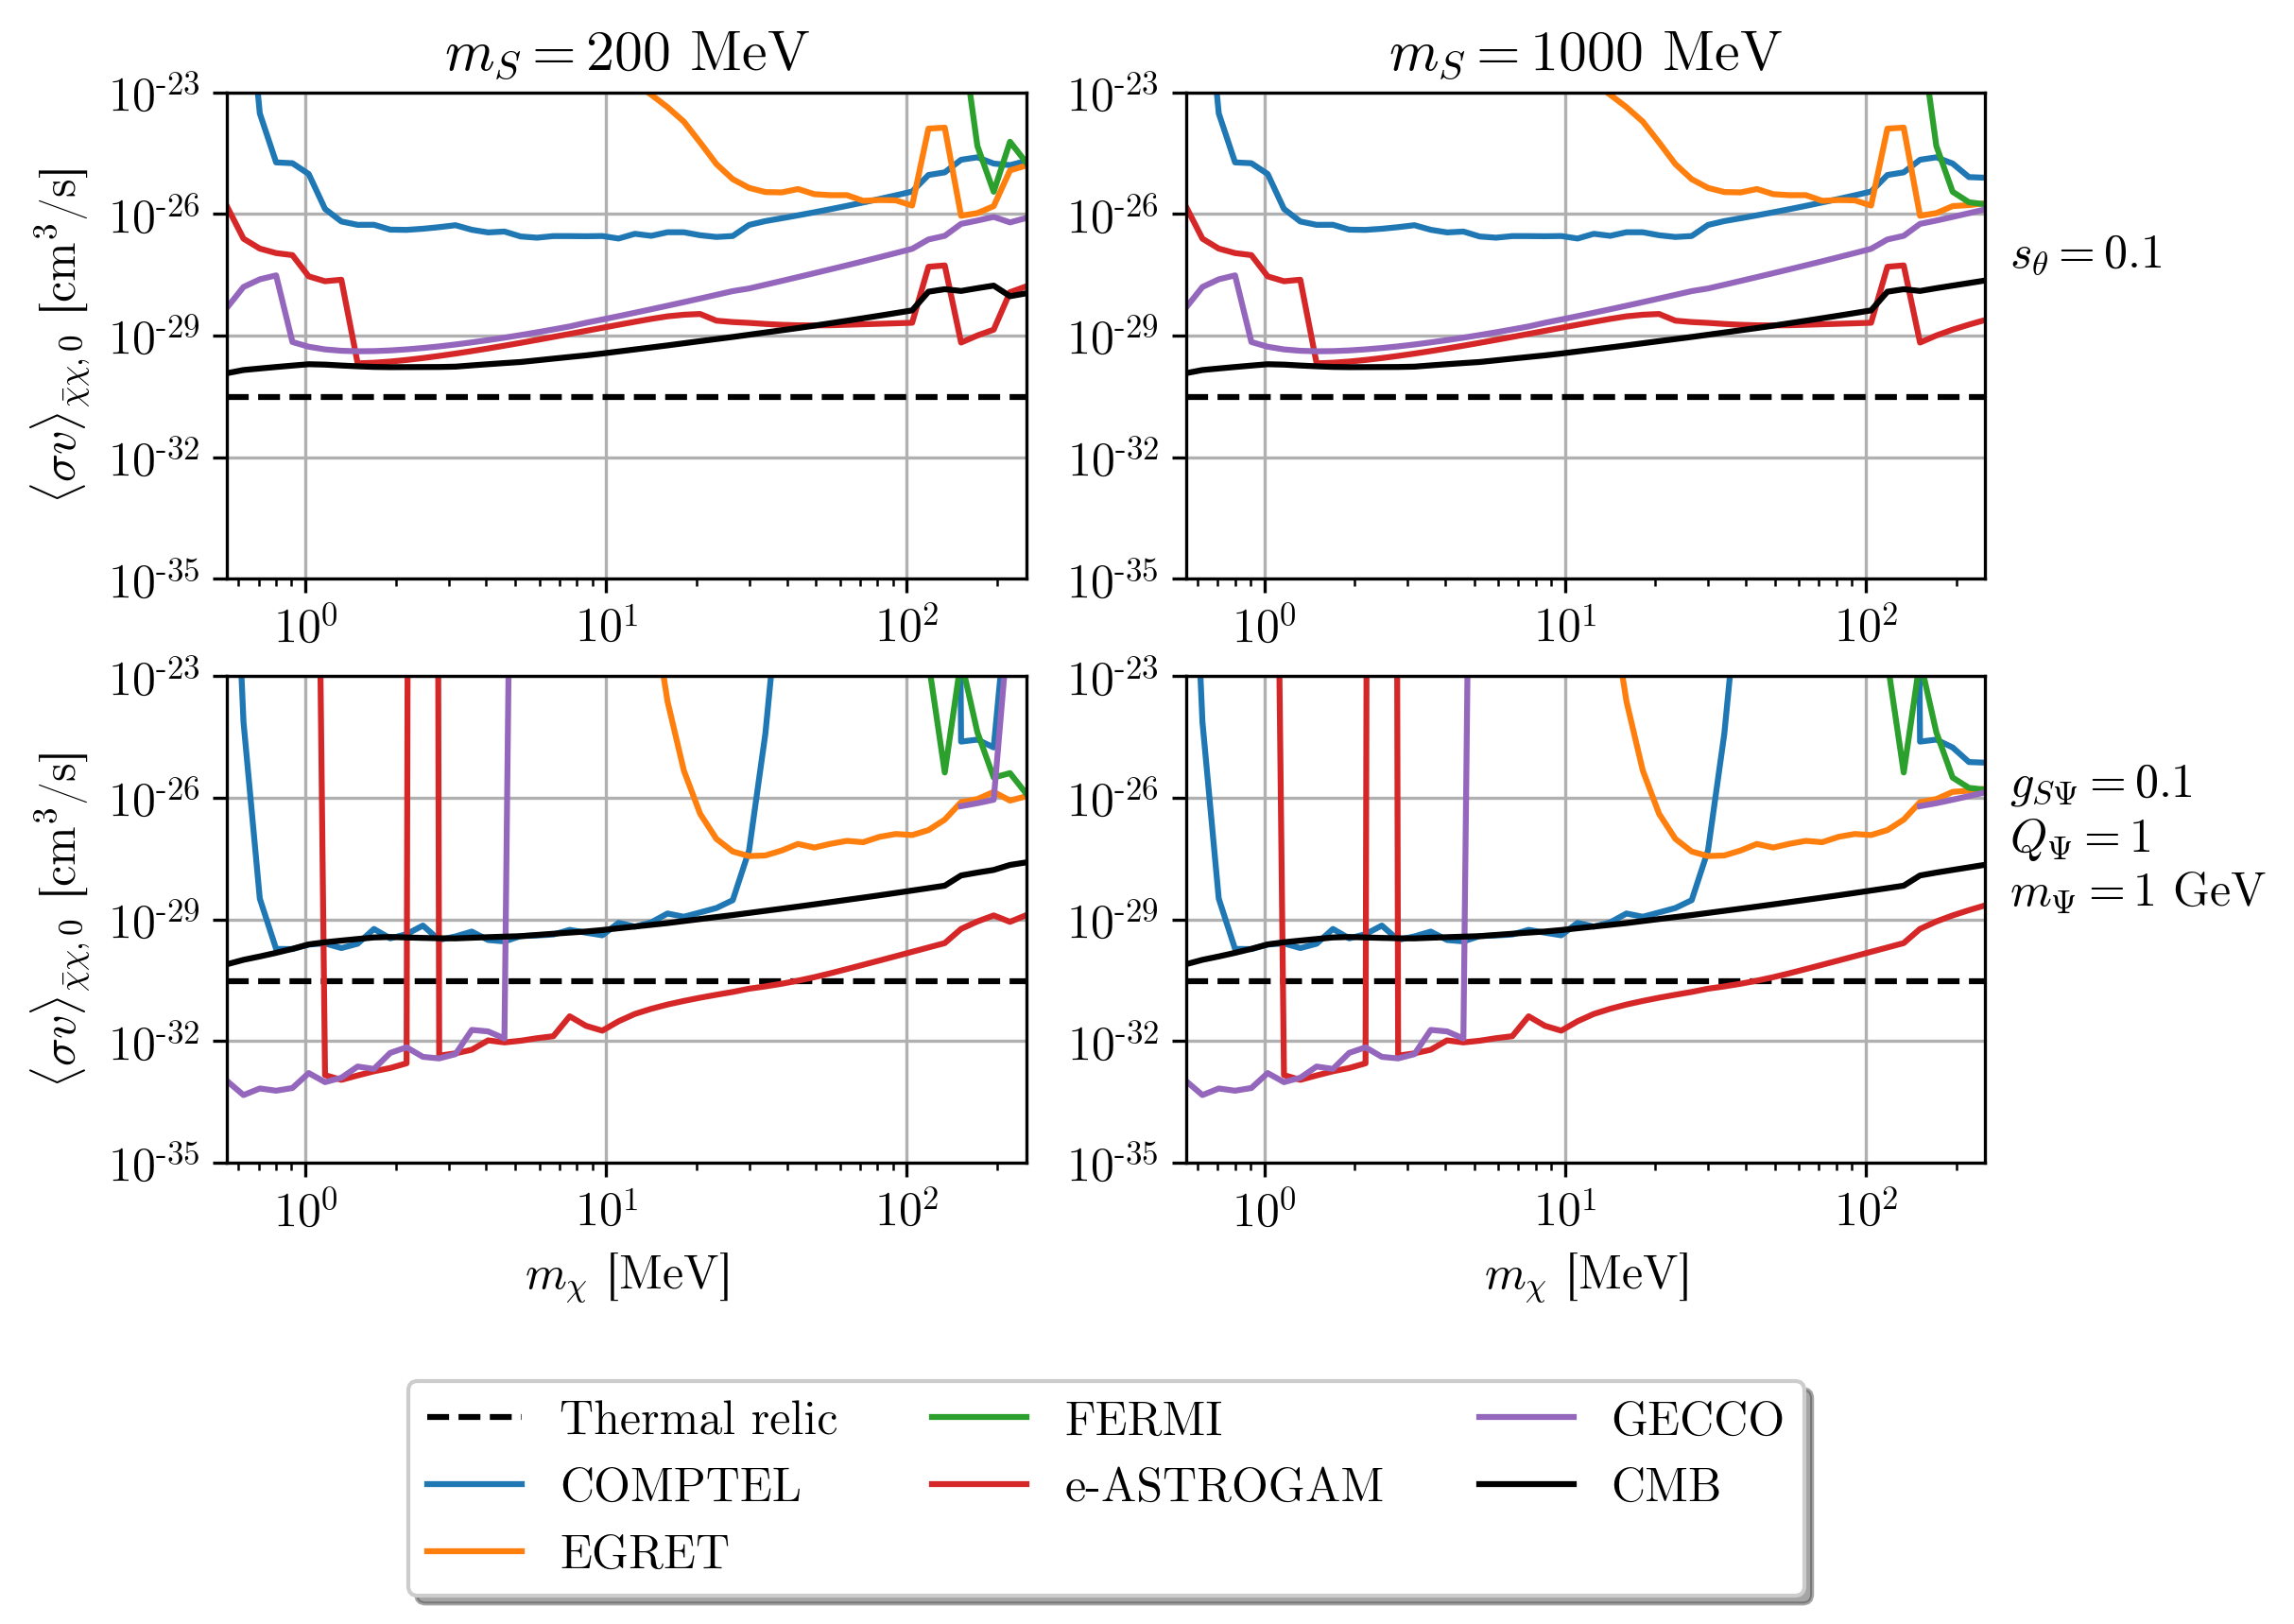

In [46]:
fig, axes = get_formatted_fig(
    *sms.shape, (4 * sms.shape[1], 2.5 * sms.shape[0]),
    mxs[[0, -1]], (1e-35, 1e-23)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Relic cross section tranlated to <sigma v> in the Milky Way
        v_fo = np.sqrt(1/10)
        ax.axhline(
            3e-26 * (v_mw / v_fo)**2, linestyle="--", color="k", label="Thermal relic"
        )
        
        # Constraints
        for key, svs in sv_constraints_sms[i, j].items():
            if key == "cmb":
                ax.plot(mxs, svs, "k", label=r"CMB")
            elif key in ["comptel_check", "gecco_large"]:
                continue
#             elif key == "comptel_check":
#                 ax.plot(mxs, svs, ":k", alpha=0.5, label=get_label(key))
            else:
                ax.plot(mxs, svs, label=get_label(key))

# Mediator mass labels
for ms, ax in zip(mss, axes[0]):
    ax.set_title(r"$m_S = $" + f"{ms} MeV")

# Coupling labels  ---------------
row_labels = [
    r"$s_\theta = %.1f$" % sms[0, -1].stheta,
    r"$g_{S\Psi} = %.1f$" % sms[1, -1].gsQ + "\n"
    + r"$Q_\Psi = %i$" % sms[1, -1].QQ + "\n"
    + r"$m_\Psi = %i$ GeV" % (sms[1, -1].mQ / 1000)
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/sm.png", bbox_inches="tight")

In [16]:
beep()

# Vector

In [23]:
mvs = [200, 1000]

vm_args = np.array([
    [{"mx": 1., "mv": mv, "gvxx": 1., "eps": 0.1} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": -1, "gvss": 0.} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": 1, "gvss": 0.} for mv in mvs]
])

VMs = np.array([
    [KineticMixing, KineticMixing],
    [QuarksOnly, QuarksOnly],
    [QuarksOnly, QuarksOnly]
])

# Instantiate all the models
vms = np.vectorize(lambda VM, args: VM(**args))(VMs, vm_args)

# Load precomputed constraints
sv_constraints_vms = np.load(
    "data/sv_constraints_vms.npz", allow_pickle=True
)["sv_constraints_vms"]

In [18]:
# Recompute constraints
sv_constraints_vms = np.empty_like(vms)
for i in range(len(vms)):
    for j in range(len(vms[i])):
        sv_constraints_vms[i, j] = get_sv_constraints(vms[i, j], mxs)

# Save results
# np.savez(
#     "data/sv_constraints_vms.npz", sv_constraints_vms=sv_constraints_vms, vm_args=vm_args
# )

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:54: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.SpectrumPoint(photon_energies, muon_energy)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_cmb.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  return p_ann * self.mx / self.f_eff(x_kd)


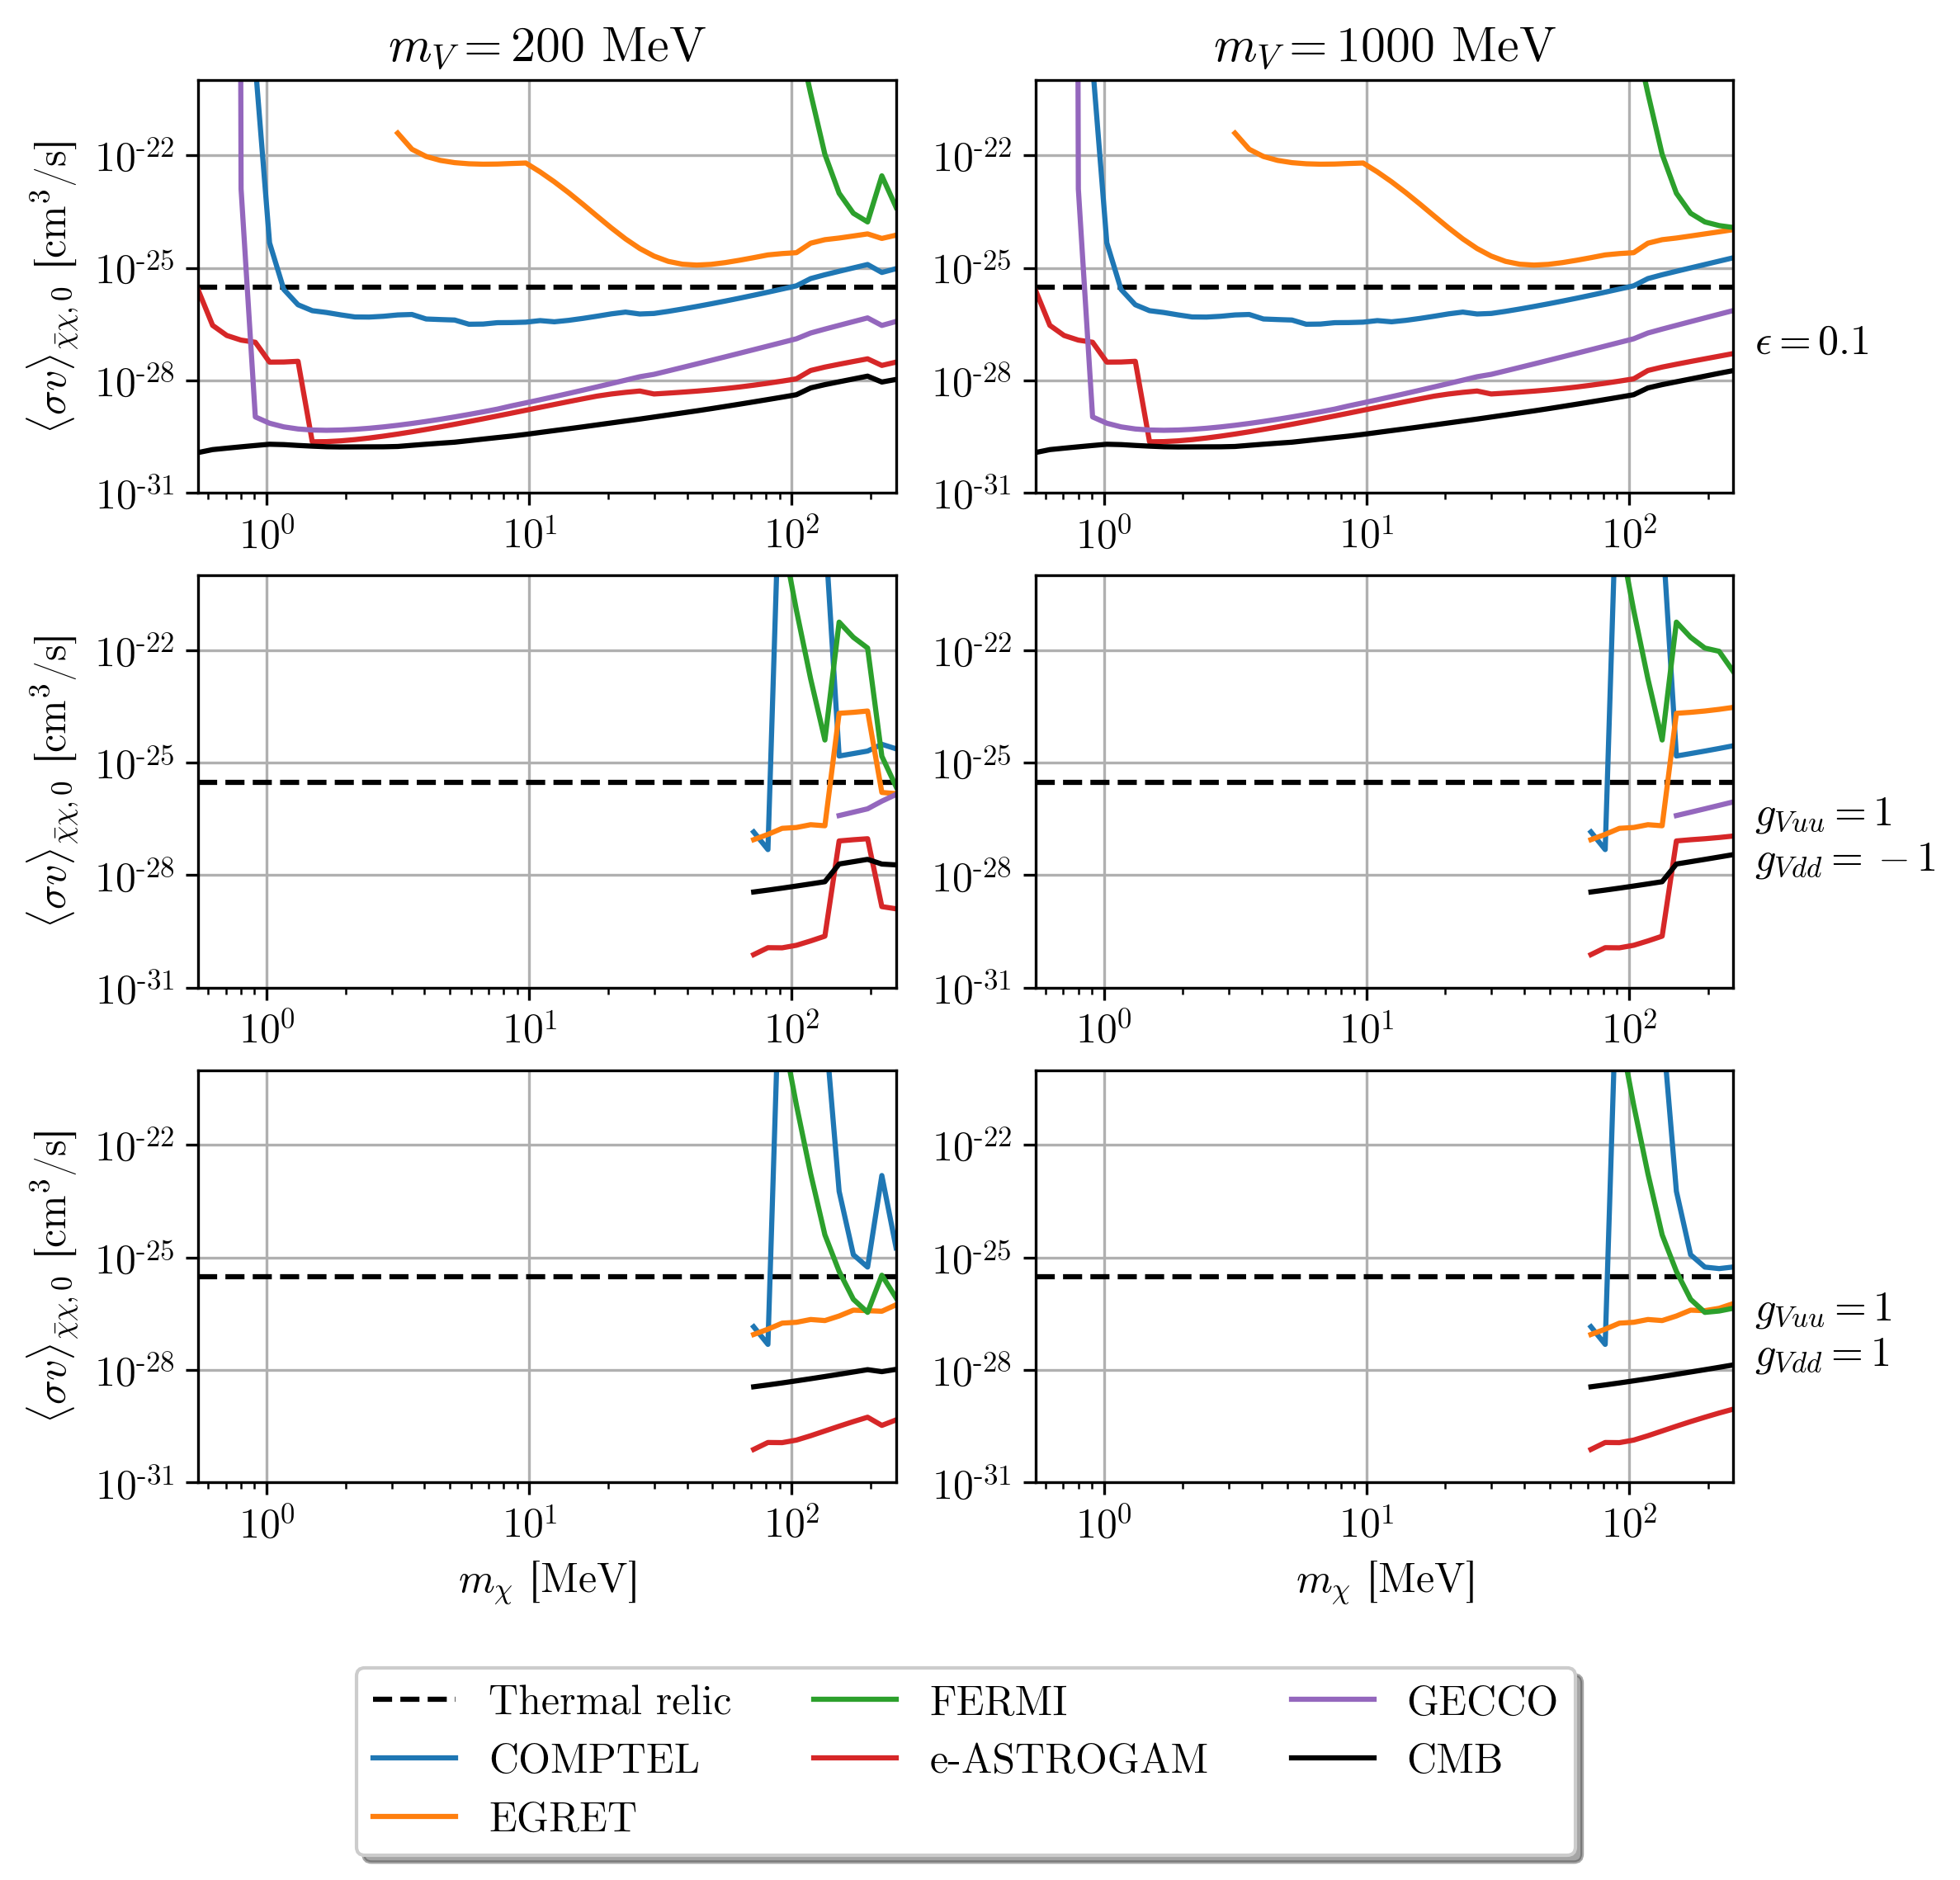

In [50]:
fig, axes = get_formatted_fig(
    *vms.shape, (4 * vms.shape[1], 2.5 * vms.shape[0]),
    mxs[[0, -1]], (1e-31, 1e-20)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle="--", color="k", label="Thermal relic")
        
        # Constraints
        for key, svs in sv_constraints_vms[i, j].items():
            if key == "cmb":
                ax.plot(mxs, svs, "k", label=r"CMB")
            elif key in ["comptel_check", "gecco_large"]:
                continue
#             elif key == "comptel_check":
#                 ax.plot(mxs, svs, ":k", alpha=0.5, label=get_label(key))
            else:
                ax.plot(mxs, svs, label=get_label(key))

# Change limits for models quark-only couplings
# for ax in axes[1:, :].flatten():
#     ax.set_xlim(50, mxs[-1])
#     ax.set_xscale("linear")

# Mediator mass labels
for mv, ax in zip(mvs, axes[0]):
    ax.set_title(r"$m_V = $" + f"{mv} MeV")

# Coupling labels
row_labels = [
    r"$\epsilon = %.1f$" % vms[0, -1].eps,
    r"$g_{Vuu} = %i$" % vms[1, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[1, -1].gvdd,
    r"$g_{Vuu} = %i$" % vms[2, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[2, -1].gvdd,
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/vm.png", bbox_inches="tight")

In [24]:
beeper.beep(frequency=900, secs=0.7, blocking=True)

# Effective areas

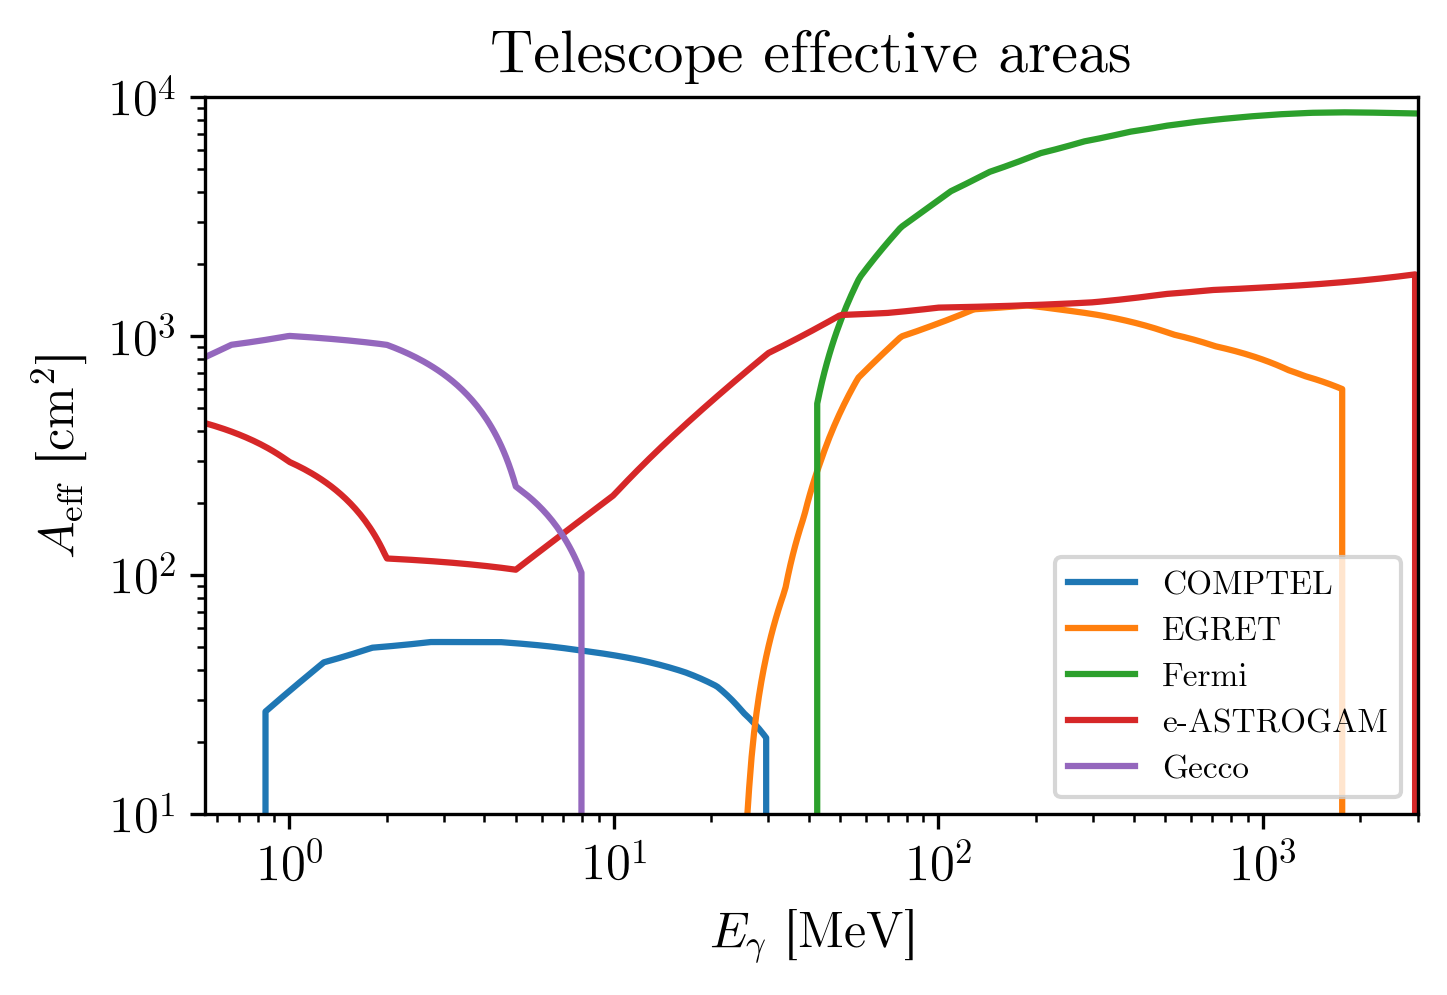

In [68]:
e_gammas = np.geomspace(0.55, 3e3, 500)

plt.plot(e_gammas, A_eff_comptel(e_gammas), label="COMPTEL")
plt.plot(e_gammas, A_eff_egret(e_gammas), label="EGRET")
plt.plot(e_gammas, A_eff_fermi(e_gammas), label="Fermi")
plt.plot(e_gammas, A_eff_e_astrogam(e_gammas), label="e-ASTROGAM")
plt.plot(e_gammas, A_eff_gecco(e_gammas), label="Gecco")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$A_\mathrm{eff}$ [cm$^2$]")
plt.xlim(e_gammas[[0, -1]])
plt.ylim(1e1, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=8)
plt.title("Telescope effective areas")

plt.tight_layout()
plt.savefig("figures/gecco/a_eff.png")